In [ ]:
"""
    do a PCA version of biomarker BHS 
    make a continuous version
    remember to do scaling / normalisation 
    label this as delta_biomarker_bhs but make new param in pipeline 
    make it amenable for complete cases or KNN imputation 
    also useful to have diagnostics for PCA - elbow plot and loadings visualisation
    for first attempt do 5 components as representative of subsystems
"""

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from adjustText import adjust_text

import sys
sys.path.append("../")

from functions.bhs_calc_functions import getAgeGroupList, getAgeThresholds, \
                                    checkListClean, biomarkerScore, count_scores

In [3]:
df = pd.read_parquet("../data/processed_data/04_ukbb_outcome_trimmed_diet.parquet")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502461 entries, 0 to 502460
Columns: 933 entries, eid to milk_type_used.0.0
dtypes: category(56), float64(621), int32(1), object(255)
memory usage: 3.3+ GB


In [5]:
# get biomarkers for bhs only 

df = df.rename(columns={"genetic_sex.0.0":"sex"})

markersList = ["glycated_haemoglobin","HDL_cholesterol","LDL_direct","triglycerides","systolic_bp","diastolic_bp",
 "pulse_rate","c.reactive_protein","IGF1","creatinine", "cystatin_C", "alanine_aminotransferase",
 "aspartate_aminotransferase","gamma_glutamyltransferase"]

biomarkersColumns = df.columns[
    df.columns.str.contains('|'.join([x+".0.0" for x in markersList]))|
    df.columns.str.contains('|'.join([x+".1.0" for x in markersList]))
].append(pd.Index(["eid", "age.0.0", "age.1.0", "sex"]))

prevalentDisease = df[
    (df["prevalentCancer"]==1)|
    (df["prevalentCad"]==1)|
    (df["prevalentCVD"]==1)]["eid"]

# population selection
biomarkersDf = df[~(df["eid"].isin(prevalentDisease)) &
                  (pd.notnull(df["sex"]))]
biomarkersDf = biomarkersDf[biomarkersColumns]

In [6]:
biomarkersDf = biomarkersDf.dropna()

In [7]:
biomarkersDf

,pulse_rate.0.0,pulse_rate.1.0,diastolic_bp.0.0,diastolic_bp.1.0,systolic_bp.0.0,systolic_bp.1.0,alanine_aminotransferase.0.0,alanine_aminotransferase.1.0,aspartate_aminotransferase.0.0,aspartate_aminotransferase.1.0,...,IGF1.0.0,IGF1.1.0,LDL_direct.0.0,LDL_direct.1.0,triglycerides.0.0,triglycerides.1.0,eid,age.0.0,age.1.0,sex
103,54.0,54.0,73.0,75.0,124.0,113.0,16.89,11.07,28.1,22.9,...,12.209,21.051,2.800,4.133,0.868,0.890,1001043,46.0,51.0,Female
177,70.0,86.0,99.0,95.0,157.0,126.0,11.94,14.20,19.4,20.5,...,21.758,25.559,3.315,3.618,0.597,0.855,1001786,54.0,60.0,Female
205,70.0,85.0,93.0,76.0,157.0,143.0,17.61,17.46,26.3,24.9,...,13.864,11.879,2.895,3.053,1.443,2.349,1002061,68.0,74.0,Male
254,64.0,70.0,77.0,73.0,120.0,127.0,16.25,16.80,24.4,24.1,...,25.592,24.583,3.860,4.555,0.771,1.170,1002553,55.0,60.0,Female
289,91.0,72.0,88.0,94.0,147.0,173.0,11.78,7.74,20.1,17.4,...,23.263,16.180,2.489,2.830,1.615,3.248,1002908,54.0,57.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502142,60.0,57.0,69.0,69.0,105.0,106.0,19.00,14.29,22.9,19.7,...,25.884,24.414,2.849,3.226,0.738,1.021,6021727,46.0,50.0,Female
502163,70.0,62.0,87.0,74.0,136.0,123.0,19.78,19.37,23.5,23.3,...,17.497,22.246,4.071,3.674,0.696,1.080,6021938,57.0,61.0,Female
502188,75.0,89.0,89.0,96.0,138.0,149.0,17.22,17.12,21.0,25.2,...,20.565,21.998,3.501,3.163,4.699,1.275,6022185,58.0,62.0,Male
502416,68.0,65.0,82.0,80.0,145.0,132.0,20.49,32.04,19.3,23.2,...,22.079,22.698,3.753,3.400,1.392,1.607,6024466,55.0,59.0,Male


In [15]:
testList = [x+'.0.0' for x in markersList]
# replace this with delta biomarkers List

In [55]:
biomarkersDf[testList]

,glycated_haemoglobin.0.0,HDL_cholesterol.0.0,LDL_direct.0.0,triglycerides.0.0,systolic_bp.0.0,diastolic_bp.0.0,pulse_rate.0.0,c.reactive_protein.0.0,IGF1.0.0,creatinine.0.0,cystatin_C.0.0,alanine_aminotransferase.0.0,aspartate_aminotransferase.0.0,gamma_glutamyltransferase.0.0
103,32.4,1.449,2.800,0.868,124.0,73.0,54.0,9.33,12.209,62.7,0.735,16.89,28.1,15.7
177,28.8,2.220,3.315,0.597,157.0,99.0,70.0,1.49,21.758,60.2,0.663,11.94,19.4,18.3
205,38.1,1.489,2.895,1.443,157.0,93.0,70.0,5.10,13.864,73.4,0.894,17.61,26.3,23.1
254,34.6,1.709,3.860,0.771,120.0,77.0,64.0,1.18,25.592,59.9,0.865,16.25,24.4,14.6
289,59.3,1.126,2.489,1.615,147.0,88.0,91.0,70.18,23.263,59.0,1.068,11.78,20.1,72.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502142,33.6,1.228,2.849,0.738,105.0,69.0,60.0,0.11,25.884,71.9,0.754,19.00,22.9,21.1
502163,34.2,1.814,4.071,0.696,136.0,87.0,70.0,1.74,17.497,65.0,0.853,19.78,23.5,18.4
502188,28.6,1.102,3.501,4.699,138.0,89.0,75.0,1.36,20.565,72.3,0.884,17.22,21.0,18.9
502416,46.0,1.423,3.753,1.392,145.0,82.0,68.0,2.75,22.079,83.1,0.909,20.49,19.3,63.7


In [66]:
n_components = 5

pipeline = Pipeline([('scaling', StandardScaler()), 
                     ('pca', PCA(n_components=n_components))])

pipelineOutput = pipeline.fit_transform(biomarkersDf[testList])
total_var = pipeline['pca'].explained_variance_ratio_.sum() * 100

In [67]:
pd.DataFrame(pipeline['pca'].components_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.157716,-0.294545,0.083108,0.340999,0.262487,0.308485,0.164663,0.111488,-0.050467,0.228568,0.273507,0.428952,0.355439,0.348773
1,-0.035395,0.122522,-0.064551,-0.094268,-0.406777,-0.417207,-0.239202,-0.109353,-0.122232,-0.141195,-0.206410,0.405198,0.481011,0.298228
2,-0.034699,-0.366470,-0.236282,0.085791,-0.326810,-0.322825,-0.224765,-0.078343,0.235068,0.530065,0.410348,-0.057500,-0.086505,-0.135007
3,0.439348,-0.245881,-0.016780,0.306938,-0.342540,-0.280742,0.370782,0.412395,-0.162582,-0.281795,-0.063212,-0.082682,-0.177644,-0.009744
4,0.199265,0.174482,-0.512336,-0.448171,0.146565,0.036610,-0.077142,0.409688,-0.429352,0.130489,0.242372,-0.036066,0.091806,-0.006629


In [38]:
total_var

60.172787948895454

In [41]:
pipeline['pca'].explained_variance_ratio_

array([0.20677001, 0.1144048 , 0.10961128, 0.08865472, 0.08228706])

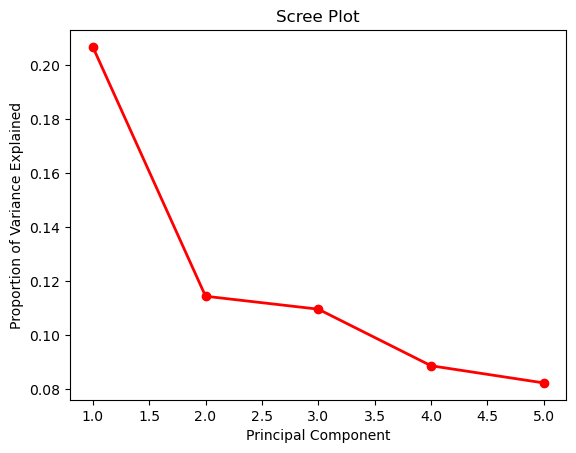

In [43]:
PC_values = np.arange(pipeline['pca'].n_components_) + 1
plt.plot(PC_values, pipeline['pca'].explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [44]:
print ("Proportion of Variance Explained : ", pipeline['pca'].explained_variance_ratio_)  
    
out_sum = np.cumsum(pipeline['pca'].explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.20677001 0.1144048  0.10961128 0.08865472 0.08228706]
Cumulative Prop. Variance Explained:  [0.20677001 0.32117481 0.43078609 0.51944082 0.60172788]


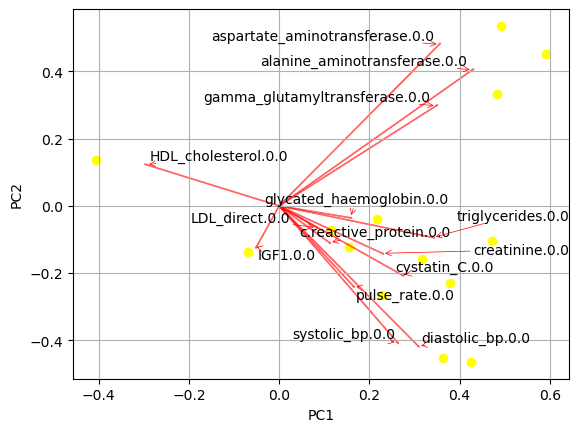

In [63]:
def mybiplot(score,coeff,labels=None,adjust=False):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = "yellow")
    
    texts = []
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            # plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
            texts.append(plt.text(coeff[i,0], coeff[i,1], labels[i]))
        
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
    if adjust:
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    
                         
#Call the function. Use only the 2 PCs.
mybiplot(pipeline['pca'].components_.T[:,0:2],np.transpose(pipeline['pca'].components_[0:2, :]),
      labels=biomarkersDf[testList].columns.to_list(),
        adjust=True)
plt.show()

In [69]:
pd.DataFrame(pipelineOutput)

,0,1,2,3,4
0,-1.672542,1.250646,-0.257166,0.772123,1.756204
1,-1.918275,-1.090300,-2.524175,-1.611994,0.318876
2,0.372533,-0.990601,-0.806468,0.065103,1.717758
3,-1.821225,0.447619,-0.017738,-0.066105,-0.369670
4,3.078975,-3.263460,-1.401841,9.169840,7.635248
...,...,...,...,...,...
6957,-2.060282,1.251198,1.431602,0.257342,-0.352610
6958,-1.043415,-0.168057,-1.126432,-0.363614,0.384729
6959,0.830301,-1.334448,0.458836,0.796194,-1.838947
6960,0.502192,-0.535808,0.235664,0.603383,0.508092


In [ ]:
# merge this as delta biomarker bhs pca version 
pd.DataFrame(pipelineOutput).mean(axis=1)

In [8]:
"""
    alternate version of pca 
    to take 1pcs of each subsystem - for 5 subsystems and take mean 
"""

# ORIGINAL BHS LIST
metabol    = ["glycated_haemoglobin","HDL_cholesterol","LDL_direct","triglycerides"]
cardio     = ["systolic_bp","diastolic_bp","pulse_rate"]
inflam     = ["c.reactive_protein","IGF1"]
renal      = ["creatinine", "cystatin_C"]
hepato     = ["alanine_aminotransferase","aspartate_aminotransferase","gamma_glutamyltransferase"]
systemNameList = ["metabol", "cardio", "inflam", "renal", "hepato"]

In [7]:
# >>> how to choose n compnents in pca 

pipeline = Pipeline([('scaling', StandardScaler()), 
                     ('pca', PCA(n_components=0.9))]).set_output(transform="pandas")


pipelineOutput = pipeline.fit_transform(biomarkersDf[biomarkersDf.columns[
    biomarkersDf.columns.str.contains('|'.join([x+".1.0" for x in metabol]))]])

In [8]:
pipelineOutput

,pca0,pca1,pca2,pca3
103,-1.405417,-0.676680,-0.164109,-0.257777
177,-2.133951,-0.237888,0.556029,0.702885
205,1.410032,0.805426,0.288810,0.110709
254,-1.023129,-1.052222,0.205896,-0.373671
289,2.838193,1.317559,1.328865,0.465044
...,...,...,...,...
502142,-0.444334,0.418135,-0.904625,-0.459857
502163,-0.569681,0.022206,-0.247691,-0.422012
502188,-0.520713,0.270750,-0.912638,-0.037526
502416,1.061981,1.006671,1.046958,-0.630521


In [9]:
pipeline['pca'].explained_variance_ratio_.sum() * 100

100.0

In [10]:
'|'.join([x+".1.0" for x in metabol])

'glycated_haemoglobin.1.0|HDL_cholesterol.1.0|LDL_direct.1.0|triglycerides.1.0'

In [11]:
pipeline = Pipeline([('scaling', StandardScaler()), 
                     ('pca', PCA(n_components=1))])

pipelineOutput = pd.DataFrame(
    pipeline.fit_transform(biomarkersDf[biomarkersDf.columns[
    biomarkersDf.columns.str.contains('|'.join([x+".1.0" for x in metabol]))]]),
    columns=["metabol"])

In [12]:
pipelineOutput

,metabol
0,-1.405417
1,-2.133951
2,1.410032
3,-1.023129
4,2.838193
...,...
6957,-0.444334
6958,-0.569681
6959,-0.520713
6960,1.061981


In [25]:
pipeline['pca'].explained_variance_ratio_.sum() * 100

37.03815307999532

In [37]:
## do implementation in function 
## output final dataframe with right column names 
## and also return proportion explained by PC 1

systemNameList = ["metabol", "cardio", "inflam", "renal", "hepato"]

pipeline = Pipeline([('scaling', StandardScaler()), 
                     ('pca', PCA(n_components=1))])

outputDfList = []
explainedVarList = []
for systemName, bioList in zip(systemNameList, [metabol, cardio, inflam, renal, hepato]):
    pipelineOutput = pd.DataFrame(
        pipeline.fit_transform(biomarkersDf[biomarkersDf.columns[
        biomarkersDf.columns.str.contains('|'.join([x+".1.0" for x in bioList]))]]),
        columns=[systemName])
    explainedVarList.append('{0:.2f}%'.format(pipeline['pca'].explained_variance_ratio_.sum() * 100))
    outputDfList.append(pipelineOutput)

In [38]:
pd.concat(outputDfList, axis=1)

,metabol,cardio,inflam,renal,hepato
0,-1.405417,-1.693592,0.050442,-1.204628,-1.136237
1,-2.133951,1.008372,1.241061,-1.877432,-1.142171
2,1.410032,0.264548,0.888856,0.495564,-0.596552
3,-1.023129,-0.901539,-0.690343,-0.792921,-0.816230
4,2.838193,2.095977,3.589121,1.243801,-0.339251
...,...,...,...,...,...
6957,-0.444334,-2.243052,-0.805563,-0.994845,-1.160060
6958,-0.569681,-1.198033,-0.288375,-0.625105,-0.715182
6959,-0.520713,1.925428,-0.296758,-0.744211,-0.724964
6960,1.061981,-0.408895,-0.309853,0.149494,1.640895


In [39]:
pd.DataFrame([explainedVarList], columns=systemNameList)

,metabol,cardio,inflam,renal,hepato
0,37.04%,56.59%,54.89%,77.46%,69.98%


In [9]:
biomarkersDf["age"] = biomarkersDf["age.0.0"]

In [10]:
for ageGroup in getAgeGroupList(biomarkersDf):
    print(biomarkersDf.loc[ageGroup,["age", "sex"]].head(2))

       age   sex
729   42.0  Male
1092  44.0  Male
      age   sex
289  54.0  Male
302  62.0  Male
      age   sex
205  68.0  Male
492  65.0  Male
       age     sex
103   46.0  Female
3233  44.0  Female
      age     sex
177  54.0  Female
254  55.0  Female
       age     sex
938   65.0  Female
2285  65.0  Female


In [11]:
### now do all together 
### change columns to delta biomarker later 

baseline = biomarkersDf[biomarkersDf.columns[
    biomarkersDf.columns.str.contains('|'.join([x+".0.0" for x in markersList]))].append(pd.Index(["sex", "eid"]))]
second = biomarkersDf[biomarkersDf.columns[
    biomarkersDf.columns.str.contains('|'.join([x+".1.0" for x in markersList]))].append(pd.Index(["sex", "eid"]))]

systemNameList = ["metabol", "cardio", "inflam", "renal", "hepato"]


# delta_biomarker_"marker"
for idx, subsystem in enumerate([metabol, cardio, inflam, renal, hepato]):
    for marker in subsystem:
        second[f"delta_biomarker_{marker}"] = second[f"{marker}.1.0"] - baseline[f"{marker}.0.0"]

deltaColumns = second.columns[second.columns.str.contains("delta_biomarker_")]

# delta_cholesterol:
# need to change the hdl to score for largest decrease over time
# if t2 - t1 = delta regular, then t2 - t1 * -1 flips this 
second["delta_biomarker_HDL_cholesterol"] = second["delta_biomarker_HDL_cholesterol"] * -1

second["age"] = biomarkersDf["age.0.0"]

/var/tmp/pbs.8144456.pbs/ipykernel_316711/3029410689.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second[f"delta_biomarker_{marker}"] = second[f"{marker}.1.0"] - baseline[f"{marker}.0.0"]
/var/tmp/pbs.8144456.pbs/ipykernel_316711/3029410689.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second[f"delta_biomarker_{marker}"] = second[f"{marker}.1.0"] - baseline[f"{marker}.0.0"]
/var/tmp/pbs.8144456.pbs/ipykernel_316711/3029410689.py:15: SettingWithCopyWarning: 
A value is trying to be set on a co

In [70]:
ageGroupNameList = ["male_49", "male_50_64", "male_65",
                        "female_49", "female_50_64", "female_65"]


pipeline = Pipeline([('scaling', StandardScaler()), 
                     ('pca', PCA(n_components=1))])

explainedVarList = []

for idx, ageGroup in enumerate(getAgeGroupList(second)):
    tempExplainedVarList = []
    tempExplainedVarList.append(ageGroupNameList[idx])
    for systemName, bioList in zip(systemNameList, [metabol, cardio, inflam, renal, hepato]):
        second.loc[ageGroup, f"delta_biomarker_{systemName}_score"] = \
            pipeline.fit_transform(second.loc[ageGroup, ["delta_biomarker_" + x for x in bioList]])
        tempExplainedVarList.append('{0:.2f}%'.format(pipeline['pca'].explained_variance_ratio_.sum() * 100))
    explainedVarList.append(tempExplainedVarList)

/var/tmp/pbs.8124198.pbs/ipykernel_2881099/1776944063.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second.loc[ageGroup, f"delta_biomarker_{systemName}_score"] = \


In [57]:
'|'.join(["delta_biomarker_" + x for x in bioList])

'delta_biomarker_glycated_haemoglobin|delta_biomarker_HDL_cholesterol|delta_biomarker_LDL_direct|delta_biomarker_triglycerides'

In [67]:
second

,pulse_rate.1.0,diastolic_bp.1.0,systolic_bp.1.0,alanine_aminotransferase.1.0,aspartate_aminotransferase.1.0,creatinine.1.0,c.reactive_protein.1.0,cystatin_C.1.0,gamma_glutamyltransferase.1.0,glycated_haemoglobin.1.0,...,delta_biomarker_cystatin_C,delta_biomarker_alanine_aminotransferase,delta_biomarker_aspartate_aminotransferase,delta_biomarker_gamma_glutamyltransferase,age,delta_biomarker_metabol_score,delta_biomarker_cardio_score,delta_biomarker_inflam_score,delta_biomarker_renal_score,delta_biomarker_hepato_score
103,54.0,75.0,113.0,11.07,22.9,67.2,2.65,0.731,18.4,31.8,...,-0.004,-5.82,-5.2,2.7,46.0,1.527139,0.481416,-2.573791,-0.072331,-0.940216
177,86.0,95.0,126.0,14.20,20.5,55.0,12.74,0.705,18.2,34.2,...,0.042,2.26,1.1,-0.1,54.0,-0.534423,1.456269,-0.803744,-0.439920,-0.116936
205,85.0,76.0,143.0,17.46,24.9,91.6,0.68,0.859,22.1,41.7,...,-0.035,-0.15,-1.4,-1.0,68.0,-1.577030,1.555731,-0.905069,0.294538,-0.158887
254,70.0,73.0,127.0,16.80,24.1,63.2,1.03,0.858,14.1,33.5,...,-0.007,0.55,-0.3,-0.5,55.0,-0.313207,0.029262,-0.042218,-0.186827,0.060155
289,72.0,94.0,173.0,7.74,17.4,71.1,19.21,1.218,103.3,49.9,...,0.150,-4.04,-2.7,31.2,54.0,-1.092365,-1.313722,8.735358,-1.599869,0.258809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502142,57.0,69.0,106.0,14.29,19.7,64.1,0.25,0.806,20.3,32.4,...,0.052,-4.71,-3.2,-0.8,46.0,0.176960,0.152555,0.134758,-0.594181,-0.830239
502163,62.0,74.0,123.0,19.37,23.3,63.3,1.60,0.893,15.4,34.4,...,0.040,-0.41,-0.2,-3.0,57.0,-0.762251,1.839211,1.048358,-0.180908,0.133632
502188,89.0,96.0,149.0,17.12,25.2,65.0,1.37,0.851,13.9,31.7,...,-0.033,-0.10,4.2,-5.0,58.0,3.293756,-1.420914,-0.362733,1.156603,0.282135
502416,65.0,80.0,132.0,32.04,23.2,79.3,1.81,0.904,120.8,45.4,...,-0.005,11.55,3.9,57.1,55.0,-0.614533,0.617432,-0.060980,0.699705,1.968447


,group,metabol,cardio,inflam,renal,hepato
0,male_49,34.74%,56.29%,52.34%,65.16%,69.96%
1,male_50_64,32.75%,54.63%,50.22%,68.32%,70.17%
2,male_65,33.46%,52.61%,55.49%,73.11%,67.50%
3,female_49,32.33%,54.70%,58.26%,56.92%,70.13%
4,female_50_64,32.09%,53.56%,56.08%,64.17%,72.37%
5,female_65,32.56%,55.27%,52.89%,75.57%,66.62%


In [78]:
def getPcaBhsSubsystem(inputDf):
    ageGroupNameList = ["male_49", "male_50_64", "male_65",
                            "female_49", "female_50_64", "female_65"]

    pipeline = Pipeline([('scaling', StandardScaler()), 
                         ('pca', PCA(n_components=1))])

    explainedVarList = []

    for idx, ageGroup in enumerate(getAgeGroupList(inputDf)):
        tempExplainedVarList = []
        tempExplainedVarList.append(ageGroupNameList[idx])
        for systemName, bioList in zip(systemNameList, [metabol, cardio, inflam, renal, hepato]):
            inputDf.loc[ageGroup, f"delta_biomarker_{systemName}_score"] = \
                pipeline.fit_transform(inputDf.loc[ageGroup, ["delta_biomarker_" + x for x in bioList]])
            tempExplainedVarList.append('{0:.2f}%'.format(pipeline['pca'].explained_variance_ratio_.sum() * 100))
        explainedVarList.append(tempExplainedVarList)
        
    explainedVarList = pd.DataFrame(explainedVarList, columns=["group"] + systemNameList)    
    return inputDf, explainedVarList

In [79]:
second, secondPcaVarList = getPcaBhsSubsystem(second)

In [80]:
secondPcaVarList

,group,metabol,cardio,inflam,renal,hepato
0,male_49,34.74%,56.29%,52.34%,65.16%,69.96%
1,male_50_64,32.75%,54.63%,50.22%,68.32%,70.17%
2,male_65,33.46%,52.61%,55.49%,73.11%,67.50%
3,female_49,32.33%,54.70%,58.26%,56.92%,70.13%
4,female_50_64,32.09%,53.56%,56.08%,64.17%,72.37%
5,female_65,32.56%,55.27%,52.89%,75.57%,66.62%


In [1]:
second

NameError: name 'second' is not defined

In [ ]:
def getPcaBhsSubsystem(inputDf, systemNameList, metabol, cardio, inflam, renal, hepato):
    ageGroupNameList = ["male_49", "male_50_64", "male_65",
                            "female_49", "female_50_64", "female_65"]

    pipeline = Pipeline([('scaling', StandardScaler()), 
                         ('pca', PCA(n_components=1))])

    explainedVarList = []

    for idx, ageGroup in enumerate(getAgeGroupList(inputDf)):
        tempExplainedVarList = []
        tempExplainedVarList.append(ageGroupNameList[idx])
        for systemName, bioList in zip(systemNameList, [metabol, cardio, inflam, renal, hepato]):
            inputDf.loc[ageGroup, f"delta_biomarker_{systemName}_score"] = \
                pipeline.fit_transform(inputDf.loc[ageGroup, ["delta_biomarker_" + x for x in bioList]])
            tempExplainedVarList.append('{0:.2f}%'.format(pipeline['pca'].explained_variance_ratio_.sum() * 100))
        explainedVarList.append(tempExplainedVarList)
        
    explainedVarList = pd.DataFrame(explainedVarList, columns=["group"] + systemNameList)    
    return inputDf, explainedVarList